In [2]:
import os
from astropy.table import Table, vstack, Column
from astropy.io import ascii
import scipy, pylab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.io import fits as pyfits

In [4]:
legacyid = Table.read("legacy-brick-id.csv")

lsbg_tab = Table()

for i in range(len(legacyid['brick'])):
    brick = legacyid['brick'][i]      # get brick number and objid from the csv file for Johnny's objects
    objid = legacyid['objid'][i]      # get objid from the csv file for Johnny's objects
    trctr = brick[0:3]                # cut out first three digits to get the tractor file number
    
    fname = '/scratch/jgreco/tractor/%s/tractor-%s.fits' %(trctr, brick)
    
    tab = Table.read(fname)           # create a table for each filename
    
    lsbg_tab = vstack([lsbg_tab, tab[objid]])   # stack every desired row into the lsbg table for reference


In [8]:
big_table = Table.read('tractor191color.csv')

In [9]:
# Make cuts to clean up the big table data 
keep = (big_table['flux_r']>0.0) & (big_table['flux_r']<1e3)

keep = (big_table['type']!="PSF ")

cname = big_table.colnames[3:]  # want everything except ra, dec data
for i in range(len(cname)):
    keep &= (big_table[cname[i]]>0.0) & (big_table[cname[i]]<1e3)
    keep &= ~np.isnan(big_table[cname[i]])
    keep &= ~np.isinf(big_table[cname[i]])

t = big_table[keep]

In [10]:
magg = (22.5-2.5*np.log10(t["flux_g"]))
magr = (22.5-2.5*np.log10(t["flux_r"]))
magz = (22.5-2.5*np.log10(t["flux_z"]))
ap_g = (22.5-2.5*np.log10(t["apflux_2.0_g"]))
ap_r = (22.5-2.5*np.log10(t["apflux_2.0_r"]))
ap_z = (22.5-2.5*np.log10(t["apflux_2.0_z"]))

# make magnitude cuts to clean up data
mask = (magg < 22.5)
mask &= (ap_g < 22.5)
mask &= (magr<23.) & (magz<23.)
mask &= (ap_r<23.) & (ap_z<23.)

mask &= (ap_g > 19.)     # cut out objects with central surface brightness (2.0 arcsec ap flux) brighter than 19.
mask &= (ap_r > 19.)
mask &= (ap_z > 19.)


mask &= t['shapeexp_r']>2.5      # cut out anything with a radius<2.5 arcsecs
t2 = t[mask].copy()

In [11]:
len(t2)

907

In [27]:
output = t2.copy()
output.rename_column('ra', 'RA')
output.rename_column('dec', 'Dec')
output['RA', 'Dec'].write('/u/tmakinen/Desktop/test2.fits')

In [12]:
# ----Cut out objects clustered around bright stars using starcoords ---- #

from astropy import units as u
from astropy.coordinates import SkyCoord
c = SkyCoord(ra=(t2['ra'])*u.degree, dec=(t2['dec'])*u.degree)


# input ra, dec arrays -- we can call each objects as c[i]

In [51]:
idx, seps, _ = c.match_to_catalog_sky(c,nthneighbor=4)

In [62]:
minsep = 60 # arcsecs
cut = seps.arcsec < minsep   # make sure we're using proper units, want to look at objects 
                             # in separation threshold to see if we've cleaned up the data
len(seps[cut])

208

In [63]:
print((seps.arcsec < minsep).sum(), 'candidates clustered in groups of three')

208 candidates clustered in groups of three


In [64]:
t3 = t2[cut].copy()

In [85]:
output = t3.copy()
output['ra', 'dec'].write('nth-neighbor.fits', overwrite=True)

In [89]:
import get_legacy_stamps
get_legacy_stamps, 'nth-neighbor.fits', "test directory"

(<module 'get_legacy_stamps' from '/u/tmakinen/repositories/ultra-diffuse-galaxy-JP/get_legacy_stamps.py'>,
 'nth-neighbor.fits',
 'test directory')

/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


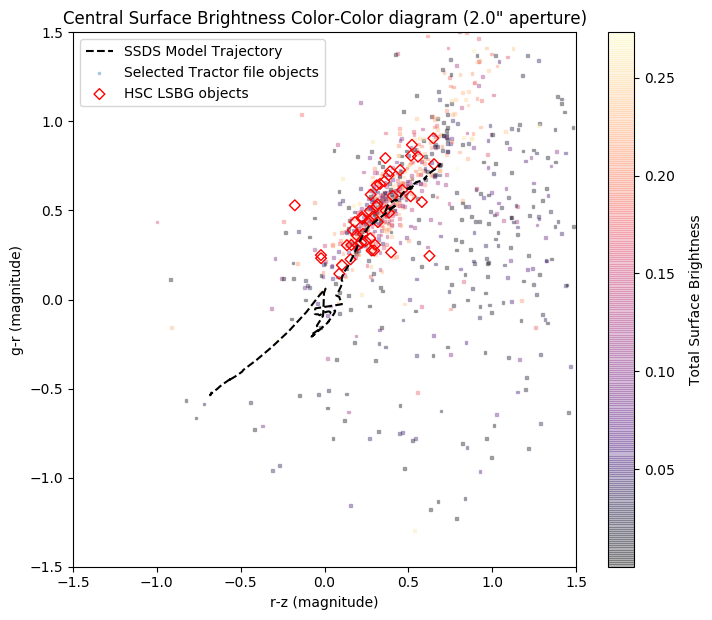

In [202]:


#------make the color-color (g-r), (r-z) band plot for aperture (data) fluxes----#
plt.style.use('default')
fig = plt.figure(221, figsize=(7.3, 6.3))
ax1 = plt.subplot(111)

# get lsbg aperture fluxes for 2.0 arcsec aperture
lsbg_apflux_r = 22.5 - 2.5*np.log10(lsbg_tab['apflux_r'][:,4])
lsbg_apflux_g = 22.5 - 2.5*np.log10(lsbg_tab['apflux_g'][:,4])
lsbg_apflux_z = 22.5 - 2.5*np.log10(lsbg_tab['apflux_z'][:,4])

# for tractor file
#mag_r = 22.5 - 2.5*np.log10(t2['apflux_2.0_r'])
#mag_g = 22.5 - 2.5*np.log10(t2['apflux_2.0_g'])
#mag_z = 22.5 - 2.5*np.log10(t2['apflux_2.0_z'])

# Do the subtraction for ratio of logs

lsgb_gr = lsbg_apflux_g - lsbg_apflux_r
lsgb_rz = lsbg_apflux_r - lsbg_apflux_z

#mag_gr = mag_g - mag_r
#mag_rz = mag_r - mag_z

ap_gr = ap_g[mask] - ap_r[mask]
ap_rz = ap_r[mask] - ap_z[mask]

# make scatterplots 
ap_sb_r = ap_r[mask]/(4*np.pi*((t2['shapeexp_r'])**2))    # total surface brightness of aperture in r band


sctrac = ax1.scatter(ap_rz, ap_gr, s=4, marker = "s", c=ap_sb_r, cmap='magma',
                     alpha=0.3, label = 'Selected Tractor file objects')
cbar = plt.colorbar(sctrac)
cbar.set_label('Total Surface Brightness',labelpad=10)


sc = ax1.scatter(lsgb_rz, lsgb_gr, s=30, marker='D', facecolors='none', alpha=1, edgecolors='r', label='HSC LSBG objects')

# add johnny's function
fn = 'bc2003_lr_BaSeL_m52_chab_ssp.1ABmag'
age, u, g, r, i, z = np.loadtxt(fn, unpack=True, usecols=(0,1,2,3,4,5))
ax1.plot(r-z, g-r, color='k', linestyle="--", label="SSDS Model Trajectory")


plt.xlim((-1.5, 1.5))
plt.ylim((-1.5, 1.5))
plt.title('Central Surface Brightness Color-Color diagram (2.0" aperture)')
plt.xlabel('r-z (magnitude)')
plt.ylabel('g-r (magnitude)')

plt.legend(loc='best')
plt.tight_layout()

plt.show()

plt.savefig("color-color-ap.png", dpi='figure', bbox_inches='tight')

/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


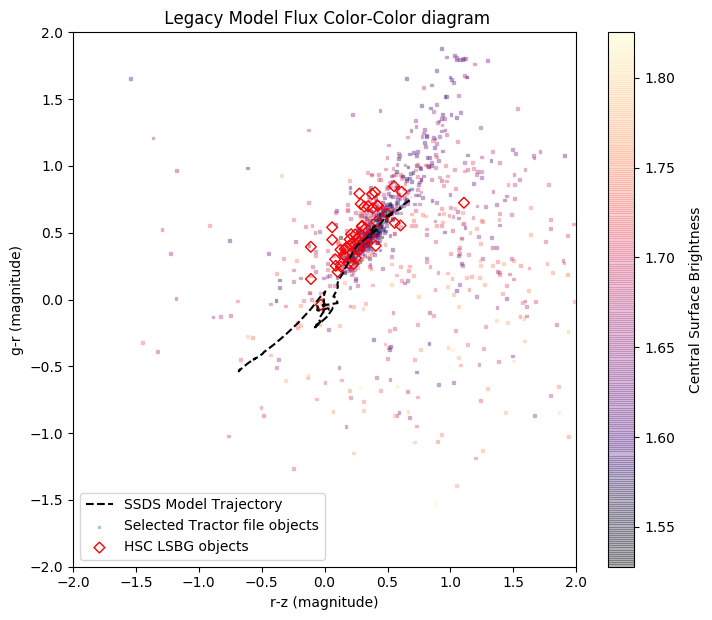

In [213]:
#------make the color-color (g-r), (r-z) band plot for the model fluxes----#
plt.style.use('default')
fig = plt.figure(221, figsize=(7.3, 6.3))
ax1 = plt.subplot(111)


# convert out of nanomaggies for lsbg table (lol) #
lsbg_mag_r = 22.5 - 2.5*np.log10(lsbg_tab['flux_r'])
lsbg_mag_g = 22.5 - 2.5*np.log10(lsbg_tab['flux_g'])
lsbg_mag_z = 22.5 - 2.5*np.log10(lsbg_tab['flux_z'])

# for tractor file
mag_r = 22.5 - 2.5*np.log10(t2['flux_r'])
mag_g = 22.5 - 2.5*np.log10(t2['flux_g'])
mag_z = 22.5 - 2.5*np.log10(t2['flux_z'])

# Do the subtraction for ratio of logs

lsgb_gr = lsbg_mag_g - lsbg_mag_r
lsgb_rz = lsbg_mag_r - lsbg_mag_z

mag_gr = mag_g - mag_r
mag_rz = mag_r - mag_z

# for central surface brightness colorbar
aperture = 2.0  # central aperture
csb_r = ap_r[mask]/(np.pi*((aperture**2)))           # central surface brightness of aperture in r band


# make scatterplots 
sctrac = ax1.scatter(mag_rz, mag_gr, s=4, marker = "s", c=csb_r, cmap='magma', alpha=0.3, label = 'Selected Tractor file objects')
sc = ax1.scatter(lsgb_rz, lsgb_gr, s=30, marker='D', facecolors='none', alpha=1, edgecolors='r', label='HSC LSBG objects')


cbar = plt.colorbar(sctrac)
cbar.set_label('Central Surface Brightness',labelpad=10)


# add johnny's function
fn = 'bc2003_lr_BaSeL_m52_chab_ssp.1ABmag'
age, u, g, r, i, z = np.loadtxt(fn, unpack=True, usecols=(0,1,2,3,4,5))
ax1.plot(r-z, g-r, color='k', linestyle="--", label="SSDS Model Trajectory")

plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.title(' Legacy Model Flux Color-Color diagram')
plt.xlabel('r-z (magnitude)')
plt.ylabel('g-r (magnitude)')

plt.legend(loc='best')
plt.tight_layout()


plt.savefig("color-color-model-good.png", dpi='figure', bbox_inches='tight')

plt.show()


/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in log10
/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in log10


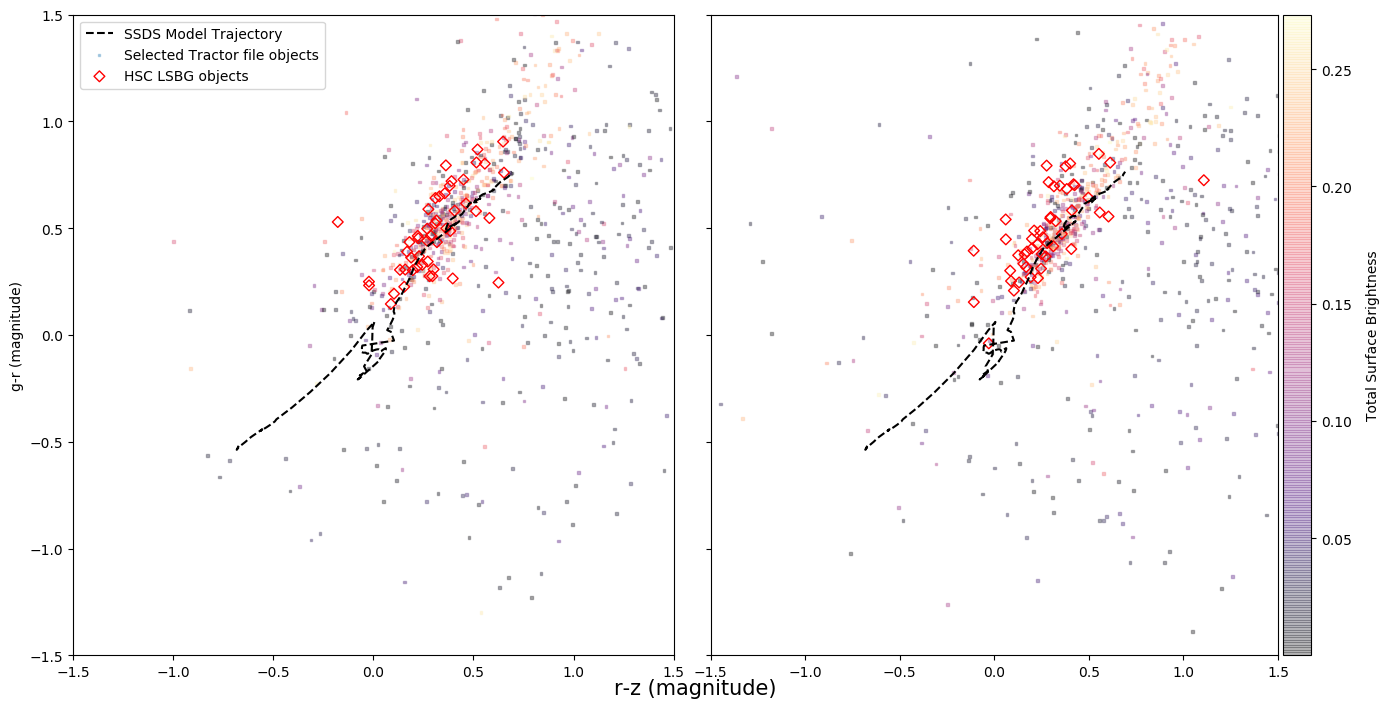

In [197]:
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

#------make the color-color (g-r), (r-z) band plot for aperture (data) fluxes----#
plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(14,7))
divider = make_axes_locatable(ax2)                        # attach cbar to axes without distortion
cax = divider.append_axes('right', size='5%', pad=0.05)   # append to right axis


# get lsbg aperture fluxes for 2.0 arcsec aperture
lsbg_apflux_r = 22.5 - 2.5*np.log10(lsbg_tab['apflux_r'][:,4])
lsbg_apflux_g = 22.5 - 2.5*np.log10(lsbg_tab['apflux_g'][:,4])
lsbg_apflux_z = 22.5 - 2.5*np.log10(lsbg_tab['apflux_z'][:,4])

# Do the subtraction for ratio of logs
# HSC objects
lsgb_gr = lsbg_apflux_g - lsbg_apflux_r
lsgb_rz = lsbg_apflux_r - lsbg_apflux_z
# tractor file
ap_gr = ap_g[mask] - ap_r[mask]
ap_rz = ap_r[mask] - ap_z[mask]

# make scatterplots 

# for total surface brightness colorbar
ap_sb_r = ap_r[mask]/(4*np.pi*((t2['shapeexp_r'])**2))           # total surface brightness of aperture in r band



sctrac = ax1.scatter(ap_rz, ap_gr, s=4, marker = "s", c=ap_sb_r, cmap='magma',
                     alpha=0.3, label = 'Selected Tractor file objects')

# make colorbar
cbar = fig.colorbar(sctrac, cax=cax, orientation='vertical')
cbar.set_label('Total Surface Brightness',labelpad=10)


sc = ax1.scatter(lsgb_rz, lsgb_gr, s=30, marker='D', facecolors='none', edgecolors='r', label='HSC LSBG objects')

# add johnny's function
fn = 'bc2003_lr_BaSeL_m52_chab_ssp.1ABmag'
age, u, g, r, i, z = np.loadtxt(fn, unpack=True, usecols=(0,1,2,3,4,5))
ax1.plot(r-z, g-r, color='k', linestyle="--", label="SSDS Model Trajectory")


ax1.set_xlim((-1.5, 1.5))
ax1.set_ylim((-1.5, 1.5))
#plt.title('Central Surface Brightness Color-Color diagram (2.0" aperture)')
#plt.xlabel('r-z (magnitude)')
ax1.set_ylabel('g-r (magnitude)')

ax1.legend(loc='best')
plt.tight_layout()






#------make the color-color (g-r), (r-z) band plot for the model fluxes----#

# convert out of nanomaggies for lsbg table (lol) #
lsbg_mag_r = 22.5 - 2.5*np.log10(lsbg_tab['flux_r'])
lsbg_mag_g = 22.5 - 2.5*np.log10(lsbg_tab['flux_g'])
lsbg_mag_z = 22.5 - 2.5*np.log10(lsbg_tab['flux_z'])

# for tractor file
mag_r = 22.5 - 2.5*np.log10(t2['flux_r'])
mag_g = 22.5 - 2.5*np.log10(t2['flux_g'])
mag_z = 22.5 - 2.5*np.log10(t2['flux_z'])

# Do the subtraction for ratio of logs

lsgb_gr = lsbg_mag_g - lsbg_mag_r
lsgb_rz = lsbg_mag_r - lsbg_mag_z

mag_gr = mag_g - mag_r
mag_rz = mag_r - mag_z


# make ax2 scatterplots 
sctrac2 = ax2.scatter(mag_rz, mag_gr, s=4, marker = "s", c=ap_sb_r, cmap='magma', alpha=0.3, label = 'Selected Tractor file objects', rasterized=True)
sc2 = ax2.scatter(lsgb_rz, lsgb_gr, s=30, marker='D', facecolors='none', edgecolors='r', label='HSC LSBG objects', rasterized=True)


#plt.colorbar(sctrac)
# add johnny's function
fn = 'bc2003_lr_BaSeL_m52_chab_ssp.1ABmag'
age, u, g, r, i, z = np.loadtxt(fn, unpack=True, usecols=(0,1,2,3,4,5))
ax2.plot(r-z, g-r, color='k', linestyle="--", label="SSDS Model Trajectory")

ax2.set_xlim((-1.5, 1.5))
ax2.set_ylim((-1.5, 1.5))

# common x-label:
fig.text(0.5, 0.0001, 'r-z (magnitude)', ha='center', fontsize=15)





plt.savefig("color-color-tractor.png", dpi='figure', bbox_inches='tight')

plt.show()

